# IMPORT DEPENDENCIES

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,log_loss
from sklearn.model_selection import cross_val_score, train_test_split, KFold, RepeatedStratifiedKFold
import os
import rasterio as rio
import rasterstats as rs
import earthpy as et
import earthpy.plot as ep
from tqdm import tqdm
import geopandas as gpd
import math
import gc
import warnings
warnings.filterwarnings('ignore')

# QUERY STARTS

In [2]:
samp = pd.read_csv(r'C:\Users\DELL\Desktop\Hackhathons\flood\SampleSubmission.csv')
df = pd.read_csv(r'C:\Users\DELL\Desktop\zindi\\externaldata.csv')

In [3]:
df.head()

,X,Y,target_2015,elevation,precip 2014-11-16 - 2014-11-23,precip 2014-11-23 - 2014-11-30,precip 2014-11-30 - 2014-12-07,precip 2014-12-07 - 2014-12-14,precip 2014-12-14 - 2014-12-21,precip 2014-12-21 - 2014-12-28,...,precip 2019-04-28 - 2019-05-05,precip 2019-05-05 - 2019-05-12,precip 2019-05-12 - 2019-05-19,LC_Type1_mode,Square_ID,geometry,Typographic_position_index,wetland_distance,malawi_srtm30meters,malawi_poverty_level
0,34.26,-15.91,0.0,887.764222,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.0,0.0,0.0,9,4e3c3896-14ce-11ea-bce5-f49634744a41,POINT (34.26 -15.91),57.0,15953.465740,0.0,95.388485
1,34.26,-15.90,0.0,743.403912,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.0,0.0,0.0,9,4e3c3897-14ce-11ea-bce5-f49634744a41,POINT (34.26 -15.9),112.0,16265.216010,742.0,95.521016
2,34.26,-15.89,0.0,565.728343,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.0,0.0,0.0,9,4e3c3898-14ce-11ea-bce5-f49634744a41,POINT (34.26 -15.89),0.0,16645.902409,607.0,95.733085
3,34.26,-15.88,0.0,443.392774,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.0,0.0,0.0,10,4e3c3899-14ce-11ea-bce5-f49634744a41,POINT (34.26 -15.88),-4.0,17087.784546,436.0,96.254659
4,34.26,-15.87,0.0,437.443428,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.0,0.0,0.0,10,4e3c389a-14ce-11ea-bce5-f49634744a41,POINT (34.26 -15.87),3.0,17589.245651,486.0,95.665613


In [4]:
# Creating lists of columns to be used in separating the dataframe into training and testing datasets
# Using a for loop for efficiency
precip_features_2019 = []
precip_features_2015 = []
for col in df.columns:
  if '2019' in col:
    precip_features_2019.append(col)
  elif 'precip 2014' in col:
    precip_features_2015.append(col)
  elif 'precip 2015' in col:
    precip_features_2015.append(col)

In [5]:
 #Separating the train dataset from the main dataframe
train = df[df.columns.difference(precip_features_2019)]
train.head(2)

,LC_Type1_mode,Square_ID,Typographic_position_index,X,Y,elevation,geometry,malawi_poverty_level,malawi_srtm30meters,precip 2014-11-16 - 2014-11-23,...,precip 2015-01-18 - 2015-01-25,precip 2015-01-25 - 2015-02-01,precip 2015-02-01 - 2015-02-08,precip 2015-02-08 - 2015-02-15,precip 2015-02-15 - 2015-02-22,precip 2015-02-22 - 2015-03-01,precip 2015-03-01 - 2015-03-08,precip 2015-03-08 - 2015-03-15,target_2015,wetland_distance
0,9,4e3c3896-14ce-11ea-bce5-f49634744a41,57.0,34.26,-15.91,887.764222,POINT (34.26 -15.91),95.388485,0.0,0.0,...,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,0.0,15953.46574
1,9,4e3c3897-14ce-11ea-bce5-f49634744a41,112.0,34.26,-15.90,743.403912,POINT (34.26 -15.9),95.521016,742.0,0.0,...,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,0.0,16265.21601


In [6]:
train.columns

Index(['LC_Type1_mode', 'Square_ID', 'Typographic_position_index', 'X', 'Y',
       'elevation', 'geometry', 'malawi_poverty_level', 'malawi_srtm30meters',
       'precip 2014-11-16 - 2014-11-23', 'precip 2014-11-23 - 2014-11-30',
       'precip 2014-11-30 - 2014-12-07', 'precip 2014-12-07 - 2014-12-14',
       'precip 2014-12-14 - 2014-12-21', 'precip 2014-12-21 - 2014-12-28',
       'precip 2014-12-28 - 2015-01-04', 'precip 2015-01-04 - 2015-01-11',
       'precip 2015-01-11 - 2015-01-18', 'precip 2015-01-18 - 2015-01-25',
       'precip 2015-01-25 - 2015-02-01', 'precip 2015-02-01 - 2015-02-08',
       'precip 2015-02-08 - 2015-02-15', 'precip 2015-02-15 - 2015-02-22',
       'precip 2015-02-22 - 2015-03-01', 'precip 2015-03-01 - 2015-03-08',
       'precip 2015-03-08 - 2015-03-15', 'target_2015', 'wetland_distance'],
      dtype='object')

In [7]:
# Separating the test dataset from the main dataframe
precip_features_2019.extend(['X','Y','elevation', 'Typographic_position_index','LC_Type1_mode','Square_ID','wetland_distance'])
test = df[precip_features_2019]
test.head(2)

,precip 2019-01-20 - 2019-01-27,precip 2019-01-27 - 2019-02-03,precip 2019-02-03 - 2019-02-10,precip 2019-02-10 - 2019-02-17,precip 2019-02-17 - 2019-02-24,precip 2019-02-24 - 2019-03-03,precip 2019-03-03 - 2019-03-10,precip 2019-03-10 - 2019-03-17,precip 2019-03-17 - 2019-03-24,precip 2019-03-24 - 2019-03-31,...,precip 2019-04-28 - 2019-05-05,precip 2019-05-05 - 2019-05-12,precip 2019-05-12 - 2019-05-19,X,Y,elevation,Typographic_position_index,LC_Type1_mode,Square_ID,wetland_distance
0,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,...,0.0,0.0,0.0,34.26,-15.91,887.764222,57.0,9,4e3c3896-14ce-11ea-bce5-f49634744a41,15953.46574
1,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,...,0.0,0.0,0.0,34.26,-15.90,743.403912,112.0,9,4e3c3897-14ce-11ea-bce5-f49634744a41,16265.21601


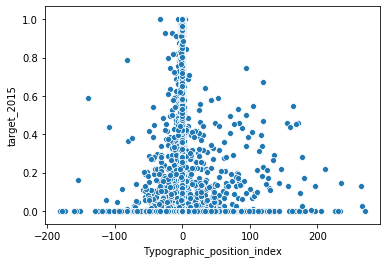

In [8]:
sns.scatterplot(x ='Typographic_position_index', y ='target_2015', data =train)

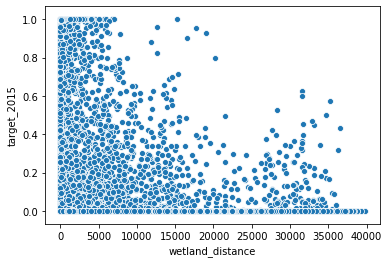

In [9]:
sns.scatterplot(x ='wetland_distance', y ='target_2015', data =train)

In [10]:
# Creating a dictionary of column names to be renamed for the training dataset
# The column names are renamed for conveniency
new_2015_cols = {}
for col, number in zip(precip_features_2015, range(1, len(precip_features_2015) + 1)):
  if 'precip' in col:
    new_2015_cols[col] = 'week_' + str(number) + '_precip'

    
# Creating a dictionary of column names to be renamed for the testing dataset
new_2019_cols = {}
for col, number in zip(precip_features_2019, range(1, len(precip_features_2019) + 1)):
  if 'precip' in col:
    new_2019_cols[col] = 'week_' + str(number) + '_precip'
    
# Renaming the columns
train.rename(columns = new_2015_cols, inplace = True)
test.rename(columns = new_2019_cols, inplace = True)

In [11]:
test.columns

Index(['week_1_precip', 'week_2_precip', 'week_3_precip', 'week_4_precip',
       'week_5_precip', 'week_6_precip', 'week_7_precip', 'week_8_precip',
       'week_9_precip', 'week_10_precip', 'week_11_precip', 'week_12_precip',
       'week_13_precip', 'week_14_precip', 'week_15_precip', 'week_16_precip',
       'week_17_precip', 'X', 'Y', 'elevation', 'Typographic_position_index',
       'LC_Type1_mode', 'Square_ID', 'wetland_distance'],
      dtype='object')

In [12]:
train.columns

Index(['LC_Type1_mode', 'Square_ID', 'Typographic_position_index', 'X', 'Y',
       'elevation', 'geometry', 'malawi_poverty_level', 'malawi_srtm30meters',
       'week_1_precip', 'week_2_precip', 'week_3_precip', 'week_4_precip',
       'week_5_precip', 'week_6_precip', 'week_7_precip', 'week_8_precip',
       'week_9_precip', 'week_10_precip', 'week_11_precip', 'week_12_precip',
       'week_13_precip', 'week_14_precip', 'week_15_precip', 'week_16_precip',
       'week_17_precip', 'target_2015', 'wetland_distance'],
      dtype='object')

In [13]:
train=train[['week_1_precip', 'week_2_precip', 'week_3_precip', 'week_4_precip',
       'week_5_precip', 'week_6_precip', 'week_7_precip', 'week_8_precip',
       'week_9_precip', 'week_10_precip', 'week_11_precip', 'week_12_precip',
       'week_13_precip', 'week_14_precip', 'week_15_precip', 'week_16_precip',
       'week_17_precip', 'X', 'Y', 'elevation', 'Typographic_position_index',
       'LC_Type1_mode', 'Square_ID', 'wetland_distance','target_2015']]

In [14]:
print(train.shape, test.shape)

(16466, 25) (16466, 24)


# OUTLIERS DETECTION

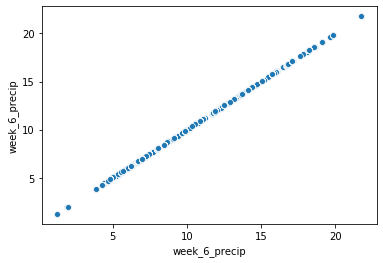

In [15]:
sns.scatterplot(x='week_6_precip', y='week_6_precip', data=train)

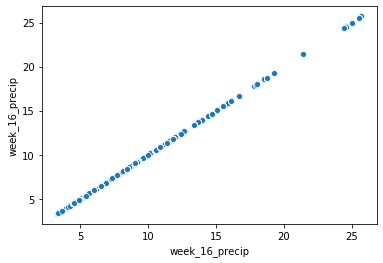

In [16]:
sns.scatterplot(x='week_16_precip', y='week_16_precip', data=train)

In [17]:
wk6 = train[train['week_6_precip'] > 21].index
wk13 = train[train['week_13_precip'] > 25].index
wk14 = train[train['week_14_precip'] > 14].index
wk15 = train[train['week_15_precip'] > 32].index
wk16 = train[train['week_16_precip'] > 20].index
wk10 = train[train['week_10_precip'] > 9].index

In [18]:
# Drop those rows from the training data.
train.drop(wk6, axis=0, inplace=True)
train.drop(wk13, axis=0, inplace=True)
train.drop(wk14, axis=0, inplace=True)
train.drop(wk15, axis=0, inplace=True)
train.drop(wk10, axis=0, inplace=True)

In [19]:
data=pd.concat([train,test],sort=False).reset_index(drop=True)
data.columns.tolist()

['week_1_precip',
 'week_2_precip',
 'week_3_precip',
 'week_4_precip',
 'week_5_precip',
 'week_6_precip',
 'week_7_precip',
 'week_8_precip',
 'week_9_precip',
 'week_10_precip',
 'week_11_precip',
 'week_12_precip',
 'week_13_precip',
 'week_14_precip',
 'week_15_precip',
 'week_16_precip',
 'week_17_precip',
 'X',
 'Y',
 'elevation',
 'Typographic_position_index',
 'LC_Type1_mode',
 'Square_ID',
 'wetland_distance',
 'target_2015']

In [20]:
#Manual computation of chikawa and nsaje (latitude and longitude) areas near to the lake
data['chikawa_X'] =34.7741
data['chikawa_Y'] =-16.1958
data['nsaje_X'] =35.2533
data['nsaje_Y'] =-16.9206

In [21]:
data.head()

,week_1_precip,week_2_precip,week_3_precip,week_4_precip,week_5_precip,week_6_precip,week_7_precip,week_8_precip,week_9_precip,week_10_precip,...,elevation,Typographic_position_index,LC_Type1_mode,Square_ID,wetland_distance,target_2015,chikawa_X,chikawa_Y,nsaje_X,nsaje_Y
0,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,...,887.764222,57.0,9,4e3c3896-14ce-11ea-bce5-f49634744a41,15953.465740,0.0,34.7741,-16.1958,35.2533,-16.9206
1,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,...,743.403912,112.0,9,4e3c3897-14ce-11ea-bce5-f49634744a41,16265.216010,0.0,34.7741,-16.1958,35.2533,-16.9206
2,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,...,565.728343,0.0,9,4e3c3898-14ce-11ea-bce5-f49634744a41,16645.902409,0.0,34.7741,-16.1958,35.2533,-16.9206
3,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,...,443.392774,-4.0,10,4e3c3899-14ce-11ea-bce5-f49634744a41,17087.784546,0.0,34.7741,-16.1958,35.2533,-16.9206
4,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,...,437.443428,3.0,10,4e3c389a-14ce-11ea-bce5-f49634744a41,17589.245651,0.0,34.7741,-16.1958,35.2533,-16.9206


In [22]:
from geopy.distance import vincenty

In [23]:
def distance_calc (row):
    start = (row['nsaje_X'], row['nsaje_Y'])
    stop = (row['X'], row['Y'])

    return vincenty(start, stop).meters

In [24]:
def distance_calc2(row):
    start = (row['chikawa_X'], row['chikawa_X'])
    stop = (row['X'], row['Y'])

    return vincenty(start, stop).meters

In [25]:
data['from_chikawa_to_axis'] = data.apply (lambda row: distance_calc2(row),axis=1)

In [26]:
data['from_nsaje_to_axis'] = data.apply (lambda row: distance_calc (row),axis=1)

In [27]:
data.head()

,week_1_precip,week_2_precip,week_3_precip,week_4_precip,week_5_precip,week_6_precip,week_7_precip,week_8_precip,week_9_precip,week_10_precip,...,LC_Type1_mode,Square_ID,wetland_distance,target_2015,chikawa_X,chikawa_Y,nsaje_X,nsaje_Y,from_chikawa_to_axis,from_nsaje_to_axis
0,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,...,9,4e3c3896-14ce-11ea-bce5-f49634744a41,15953.465740,0.0,34.7741,-16.1958,35.2533,-16.9206,4.602924e+06,143886.494791
1,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,...,9,4e3c3897-14ce-11ea-bce5-f49634744a41,16265.216010,0.0,34.7741,-16.1958,35.2533,-16.9206,4.602037e+06,144476.923418
2,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,...,9,4e3c3898-14ce-11ea-bce5-f49634744a41,16645.902409,0.0,34.7741,-16.1958,35.2533,-16.9206,4.601150e+06,145070.726844
3,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,...,10,4e3c3899-14ce-11ea-bce5-f49634744a41,17087.784546,0.0,34.7741,-16.1958,35.2533,-16.9206,4.600264e+06,145667.863794
4,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,...,10,4e3c389a-14ce-11ea-bce5-f49634744a41,17589.245651,0.0,34.7741,-16.1958,35.2533,-16.9206,4.599377e+06,146268.293433


In [28]:
data.head()

,week_1_precip,week_2_precip,week_3_precip,week_4_precip,week_5_precip,week_6_precip,week_7_precip,week_8_precip,week_9_precip,week_10_precip,...,LC_Type1_mode,Square_ID,wetland_distance,target_2015,chikawa_X,chikawa_Y,nsaje_X,nsaje_Y,from_chikawa_to_axis,from_nsaje_to_axis
0,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,...,9,4e3c3896-14ce-11ea-bce5-f49634744a41,15953.465740,0.0,34.7741,-16.1958,35.2533,-16.9206,4.602924e+06,143886.494791
1,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,...,9,4e3c3897-14ce-11ea-bce5-f49634744a41,16265.216010,0.0,34.7741,-16.1958,35.2533,-16.9206,4.602037e+06,144476.923418
2,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,...,9,4e3c3898-14ce-11ea-bce5-f49634744a41,16645.902409,0.0,34.7741,-16.1958,35.2533,-16.9206,4.601150e+06,145070.726844
3,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,...,10,4e3c3899-14ce-11ea-bce5-f49634744a41,17087.784546,0.0,34.7741,-16.1958,35.2533,-16.9206,4.600264e+06,145667.863794
4,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,...,10,4e3c389a-14ce-11ea-bce5-f49634744a41,17589.245651,0.0,34.7741,-16.1958,35.2533,-16.9206,4.599377e+06,146268.293433


In [29]:
features=features=[ 'week_1_precip','week_2_precip','week_3_precip', 'week_4_precip', 'week_5_precip',
          'week_6_precip', 'week_7_precip', 'week_8_precip', 'week_9_precip',
          'week_10_precip', 'week_11_precip', 'week_12_precip', 'week_13_precip',
          'week_14_precip', 'week_15_precip', 'week_16_precip', 'week_17_precip','Typographic_position_index'
         ]

In [30]:
def aggregate_features(x,col_name):
    x["max_"+col_name]=x[col_name].apply(np.max)
    x["mean_"+col_name]=x[col_name].apply(np.mean)
    x["median_"+col_name]=x[col_name].apply(np.median)
    return x  

In [31]:
for col_name in tqdm(features):
    data=aggregate_features(data,col_name)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:42<00:00,  2.38s/it]


In [32]:
train=data[data.target_2015.notnull()].reset_index(drop=True)
test=data[data.target_2015.isna()].reset_index(drop=True)

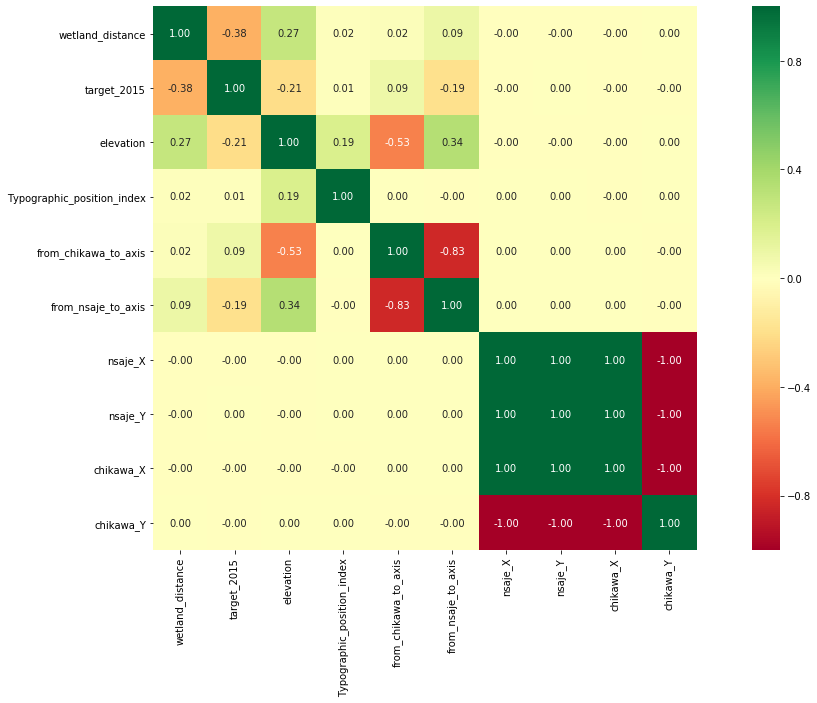

In [33]:
#correlelogram- plot heatmap to find correlation among features
corrmat =train.corr()
f, ax = plt.subplots(figsize=(20,10))
sns.heatmap(train[['wetland_distance','target_2015','elevation','Typographic_position_index','from_chikawa_to_axis','from_nsaje_to_axis','nsaje_X','nsaje_Y','chikawa_X','chikawa_Y']].corr(), square=True, cmap=plt.cm.RdYlGn, annot=True, fmt=".2f")
#wk1, wk2, wk3 -same multicollinearity

In [34]:
test=test.drop(['chikawa_X','chikawa_Y','nsaje_X','nsaje_Y'], axis=1)
train=train.drop(['chikawa_X','chikawa_Y','nsaje_X','nsaje_Y'], axis=1)

In [35]:
test_id = test['Square_ID']

In [36]:
train = train.drop(['Square_ID'], axis=1)

In [37]:
test = test.drop(['Square_ID'], axis=1)

In [38]:
test = test.drop('target_2015', axis=1)

In [39]:
def threshold(x):
    if x >= 0.40:
        return 1
    else:
        return 0
train['target_2015'] = train['target_2015'].apply(threshold)

In [40]:
X = train.drop(['target_2015'], axis=1)
y = train['target_2015']

In [41]:
X_fold, X_val, y_fold, y_val = train_test_split(X, y, test_size=0.25, random_state=12345)

In [42]:
param = { 
         'objective':'binary','sub_sample':0.9,
         'max_depth': -1,
         'learning_rate': 0.03,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "metric": 'auc',
        'seed':1899,
         "verbose": -0}

In [43]:
errcb=[]
y_pred_totcb=[]
fold=RepeatedStratifiedKFold(n_splits=12, random_state=273, n_repeats=6)
for train_index, test_index in fold.split(X_fold,y_fold):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m=CatBoostClassifier(n_estimators=1500,learning_rate=0.07,depth=8,random_seed=12345, eval_metric='AUC', use_best_model=True)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train)],verbose=100, early_stopping_rounds=300)#,verbose=100)
    preds=m.predict_proba(X_test)
    print("err: ",log_loss(y_test,preds))
    errcb.append(log_loss(y_test,preds))
    p = m.predict_proba(test)[:,1]
    y_pred_totcb.append(p)

0:	test: 0.9499380	best: 0.9499380 (0)	total: 298ms	remaining: 7m 27s
100:	test: 0.9940928	best: 0.9940928 (100)	total: 6.2s	remaining: 1m 25s
200:	test: 0.9976228	best: 0.9976228 (200)	total: 11.9s	remaining: 1m 16s
300:	test: 0.9991919	best: 0.9991919 (300)	total: 17.6s	remaining: 1m 10s
400:	test: 0.9997040	best: 0.9997040 (400)	total: 23.4s	remaining: 1m 4s
500:	test: 0.9998678	best: 0.9998678 (500)	total: 29.6s	remaining: 59s
600:	test: 0.9999482	best: 0.9999485 (599)	total: 35.3s	remaining: 52.8s
700:	test: 0.9999892	best: 0.9999892 (700)	total: 42.1s	remaining: 48s
800:	test: 0.9999970	best: 0.9999970 (794)	total: 48.3s	remaining: 42.1s
900:	test: 0.9999993	best: 0.9999993 (900)	total: 53.9s	remaining: 35.9s
1000:	test: 0.9999997	best: 0.9999999 (983)	total: 59.7s	remaining: 29.8s
1100:	test: 1.0000000	best: 1.0000000 (1038)	total: 1m 5s	remaining: 23.9s
1200:	test: 1.0000000	best: 1.0000000 (1038)	total: 1m 11s	remaining: 17.9s
1300:	test: 1.0000000	best: 1.0000000 (1038)	total

1100:	test: 1.0000000	best: 1.0000000 (972)	total: 1m 15s	remaining: 27.4s
1200:	test: 1.0000000	best: 1.0000000 (972)	total: 1m 22s	remaining: 20.7s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 1
bestIteration = 972

Shrink model to first 973 iterations.
err:  0.05685113669951817
0:	test: 0.9509028	best: 0.9509028 (0)	total: 67.7ms	remaining: 1m 41s
100:	test: 0.9945928	best: 0.9945928 (100)	total: 9.18s	remaining: 2m 7s
200:	test: 0.9980236	best: 0.9980236 (200)	total: 15.2s	remaining: 1m 38s
300:	test: 0.9991315	best: 0.9991315 (300)	total: 21.7s	remaining: 1m 26s
400:	test: 0.9995943	best: 0.9995943 (400)	total: 27.7s	remaining: 1m 15s
500:	test: 0.9998799	best: 0.9998799 (500)	total: 33.5s	remaining: 1m 6s
600:	test: 0.9999417	best: 0.9999417 (598)	total: 39.1s	remaining: 58.6s
700:	test: 0.9999822	best: 0.9999825 (697)	total: 45.7s	remaining: 52.1s
800:	test: 0.9999952	best: 0.9999952 (796)	total: 53.1s	remaining: 46.3s
900:	test: 0.9999986	best: 0.9999987 (

900:	test: 0.9999979	best: 0.9999979 (882)	total: 1m 2s	remaining: 41.4s
1000:	test: 0.9999994	best: 0.9999994 (992)	total: 1m 8s	remaining: 34.1s
1100:	test: 0.9999999	best: 0.9999999 (1092)	total: 1m 14s	remaining: 27s
1200:	test: 0.9999999	best: 0.9999999 (1092)	total: 1m 21s	remaining: 20.2s
1300:	test: 1.0000000	best: 1.0000000 (1254)	total: 1m 28s	remaining: 13.5s
1400:	test: 1.0000000	best: 1.0000000 (1254)	total: 1m 36s	remaining: 6.79s
1499:	test: 1.0000000	best: 1.0000000 (1254)	total: 1m 44s	remaining: 0us

bestTest = 1
bestIteration = 1254

Shrink model to first 1255 iterations.
err:  0.084604788026252
0:	test: 0.9486246	best: 0.9486246 (0)	total: 70.8ms	remaining: 1m 46s
100:	test: 0.9945122	best: 0.9945122 (100)	total: 6.62s	remaining: 1m 31s
200:	test: 0.9981265	best: 0.9981265 (200)	total: 12.9s	remaining: 1m 23s
300:	test: 0.9992269	best: 0.9992269 (300)	total: 19.3s	remaining: 1m 16s
400:	test: 0.9996921	best: 0.9996921 (400)	total: 25.3s	remaining: 1m 9s
500:	test: 0

300:	test: 0.9990301	best: 0.9990301 (300)	total: 23.4s	remaining: 1m 33s
400:	test: 0.9995810	best: 0.9995810 (400)	total: 31.1s	remaining: 1m 25s
500:	test: 0.9999058	best: 0.9999058 (500)	total: 38.2s	remaining: 1m 16s
600:	test: 0.9999797	best: 0.9999797 (600)	total: 44.9s	remaining: 1m 7s
700:	test: 0.9999949	best: 0.9999949 (700)	total: 53s	remaining: 1m
800:	test: 0.9999986	best: 0.9999986 (793)	total: 1m 1s	remaining: 54.1s
900:	test: 0.9999999	best: 0.9999999 (900)	total: 1m 11s	remaining: 47.3s
1000:	test: 0.9999999	best: 0.9999999 (900)	total: 1m 17s	remaining: 38.7s
1100:	test: 0.9999999	best: 0.9999999 (900)	total: 1m 24s	remaining: 30.5s
1200:	test: 1.0000000	best: 1.0000000 (1129)	total: 1m 31s	remaining: 22.8s
1300:	test: 1.0000000	best: 1.0000000 (1129)	total: 1m 38s	remaining: 15s
1400:	test: 1.0000000	best: 1.0000000 (1129)	total: 1m 45s	remaining: 7.42s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 1
bestIteration = 1129

Shrink model to first 1

1100:	test: 0.9999999	best: 1.0000000 (1089)	total: 1m 22s	remaining: 29.8s
1200:	test: 1.0000000	best: 1.0000000 (1089)	total: 1m 27s	remaining: 21.9s
1300:	test: 1.0000000	best: 1.0000000 (1089)	total: 1m 33s	remaining: 14.3s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 1
bestIteration = 1089

Shrink model to first 1090 iterations.
err:  0.10274974668279264
0:	test: 0.9501176	best: 0.9501176 (0)	total: 78.7ms	remaining: 1m 57s
100:	test: 0.9941533	best: 0.9941533 (100)	total: 5.9s	remaining: 1m 21s
200:	test: 0.9975640	best: 0.9975640 (200)	total: 11.6s	remaining: 1m 15s
300:	test: 0.9990376	best: 0.9990376 (300)	total: 17.3s	remaining: 1m 8s
400:	test: 0.9995575	best: 0.9995575 (400)	total: 23.4s	remaining: 1m 4s
500:	test: 0.9998214	best: 0.9998214 (500)	total: 30.1s	remaining: 1m
600:	test: 0.9999067	best: 0.9999067 (600)	total: 38s	remaining: 56.9s
700:	test: 0.9999558	best: 0.9999560 (699)	total: 46.7s	remaining: 53.3s
800:	test: 0.9999884	best: 0.9999884 (

400:	test: 0.9995331	best: 0.9995331 (400)	total: 25.2s	remaining: 1m 8s
500:	test: 0.9998101	best: 0.9998101 (500)	total: 31.1s	remaining: 1m 2s
600:	test: 0.9999384	best: 0.9999387 (599)	total: 38.1s	remaining: 57s
700:	test: 0.9999757	best: 0.9999759 (697)	total: 46s	remaining: 52.4s
800:	test: 0.9999900	best: 0.9999900 (799)	total: 54.3s	remaining: 47.4s
900:	test: 0.9999941	best: 0.9999941 (899)	total: 1m 1s	remaining: 41s
1000:	test: 0.9999987	best: 0.9999987 (998)	total: 1m 8s	remaining: 34.3s
1100:	test: 0.9999994	best: 0.9999994 (1069)	total: 1m 14s	remaining: 27s
1200:	test: 0.9999999	best: 0.9999999 (1142)	total: 1m 20s	remaining: 19.9s
1300:	test: 1.0000000	best: 1.0000000 (1229)	total: 1m 26s	remaining: 13.2s
1400:	test: 1.0000000	best: 1.0000000 (1229)	total: 1m 32s	remaining: 6.56s
1499:	test: 1.0000000	best: 1.0000000 (1229)	total: 1m 39s	remaining: 0us

bestTest = 1
bestIteration = 1229

Shrink model to first 1230 iterations.
err:  0.09068577970510344
0:	test: 0.948093

100:	test: 0.9939639	best: 0.9939639 (100)	total: 6.04s	remaining: 1m 23s
200:	test: 0.9978441	best: 0.9978441 (200)	total: 11.8s	remaining: 1m 15s
300:	test: 0.9991291	best: 0.9991291 (300)	total: 19s	remaining: 1m 15s
400:	test: 0.9995902	best: 0.9995902 (400)	total: 26.6s	remaining: 1m 13s
500:	test: 0.9998572	best: 0.9998572 (500)	total: 35.2s	remaining: 1m 10s
600:	test: 0.9999245	best: 0.9999245 (598)	total: 41.3s	remaining: 1m 1s
700:	test: 0.9999729	best: 0.9999729 (700)	total: 47s	remaining: 53.5s
800:	test: 0.9999919	best: 0.9999919 (800)	total: 52.6s	remaining: 45.9s
900:	test: 0.9999989	best: 0.9999989 (889)	total: 58.3s	remaining: 38.8s
1000:	test: 0.9999999	best: 1.0000000 (985)	total: 1m 4s	remaining: 32s
1100:	test: 1.0000000	best: 1.0000000 (985)	total: 1m 10s	remaining: 25.5s
1200:	test: 1.0000000	best: 1.0000000 (985)	total: 1m 16s	remaining: 19.1s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 1
bestIteration = 985

Shrink model to first 986 iter

err:  0.07503102738534
0:	test: 0.9530904	best: 0.9530904 (0)	total: 65.6ms	remaining: 1m 38s
100:	test: 0.9940950	best: 0.9940950 (100)	total: 7.68s	remaining: 1m 46s
200:	test: 0.9976764	best: 0.9976764 (200)	total: 16s	remaining: 1m 43s
300:	test: 0.9990519	best: 0.9990519 (300)	total: 21.5s	remaining: 1m 25s
400:	test: 0.9995617	best: 0.9995617 (400)	total: 27s	remaining: 1m 14s
500:	test: 0.9997994	best: 0.9997994 (500)	total: 32.5s	remaining: 1m 4s
600:	test: 0.9999196	best: 0.9999198 (599)	total: 38.1s	remaining: 57s
700:	test: 0.9999734	best: 0.9999734 (700)	total: 43.6s	remaining: 49.7s
800:	test: 0.9999900	best: 0.9999902 (792)	total: 49.1s	remaining: 42.9s
900:	test: 0.9999968	best: 0.9999970 (891)	total: 55.4s	remaining: 36.8s
1000:	test: 0.9999987	best: 0.9999987 (986)	total: 1m 1s	remaining: 30.8s
1100:	test: 0.9999997	best: 0.9999997 (1098)	total: 1m 9s	remaining: 25.1s
1200:	test: 1.0000000	best: 1.0000000 (1186)	total: 1m 18s	remaining: 19.4s
1300:	test: 1.0000000	best

1300:	test: 1.0000000	best: 1.0000000 (1113)	total: 1m 43s	remaining: 15.8s
1400:	test: 1.0000000	best: 1.0000000 (1113)	total: 1m 51s	remaining: 7.87s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 1
bestIteration = 1113

Shrink model to first 1114 iterations.
err:  0.05135424938697691
0:	test: 0.9500110	best: 0.9500110 (0)	total: 139ms	remaining: 3m 28s
100:	test: 0.9934877	best: 0.9934877 (100)	total: 11.9s	remaining: 2m 44s
200:	test: 0.9973836	best: 0.9973836 (200)	total: 19.6s	remaining: 2m 6s
300:	test: 0.9989088	best: 0.9989088 (300)	total: 27.2s	remaining: 1m 48s
400:	test: 0.9995780	best: 0.9995780 (400)	total: 34.9s	remaining: 1m 35s
500:	test: 0.9998132	best: 0.9998132 (500)	total: 43.4s	remaining: 1m 26s
600:	test: 0.9999099	best: 0.9999099 (600)	total: 52.2s	remaining: 1m 18s
700:	test: 0.9999560	best: 0.9999560 (700)	total: 1m 2s	remaining: 1m 10s
800:	test: 0.9999868	best: 0.9999868 (800)	total: 1m 14s	remaining: 1m 5s
900:	test: 0.9999954	best: 0.99

700:	test: 0.9999682	best: 0.9999682 (700)	total: 44.4s	remaining: 50.7s
800:	test: 0.9999891	best: 0.9999891 (798)	total: 50.6s	remaining: 44.1s
900:	test: 0.9999967	best: 0.9999967 (898)	total: 56.4s	remaining: 37.5s
1000:	test: 0.9999993	best: 0.9999993 (1000)	total: 1m 1s	remaining: 30.9s
1100:	test: 0.9999997	best: 0.9999997 (1040)	total: 1m 7s	remaining: 24.5s
1200:	test: 0.9999997	best: 0.9999997 (1040)	total: 1m 13s	remaining: 18.2s
1300:	test: 1.0000000	best: 1.0000000 (1263)	total: 1m 18s	remaining: 12s
1400:	test: 1.0000000	best: 1.0000000 (1263)	total: 1m 24s	remaining: 5.95s
1499:	test: 1.0000000	best: 1.0000000 (1263)	total: 1m 30s	remaining: 0us

bestTest = 1
bestIteration = 1263

Shrink model to first 1264 iterations.
err:  0.06163994029074033
0:	test: 0.9553351	best: 0.9553351 (0)	total: 72.8ms	remaining: 1m 49s
100:	test: 0.9943821	best: 0.9943821 (100)	total: 7.99s	remaining: 1m 50s
200:	test: 0.9978304	best: 0.9978304 (200)	total: 15.6s	remaining: 1m 40s
300:	test: 

1300:	test: 1.0000000	best: 1.0000000 (1042)	total: 2m 57s	remaining: 27.2s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 1
bestIteration = 1042

Shrink model to first 1043 iterations.
err:  0.07733174647705683
0:	test: 0.9472124	best: 0.9472124 (0)	total: 204ms	remaining: 5m 5s
100:	test: 0.9936877	best: 0.9936877 (100)	total: 13.5s	remaining: 3m 7s
200:	test: 0.9976385	best: 0.9976385 (200)	total: 27.6s	remaining: 2m 58s
300:	test: 0.9991180	best: 0.9991180 (300)	total: 42.1s	remaining: 2m 47s
400:	test: 0.9996726	best: 0.9996726 (400)	total: 56.6s	remaining: 2m 35s
500:	test: 0.9998214	best: 0.9998214 (500)	total: 1m 12s	remaining: 2m 24s
600:	test: 0.9999230	best: 0.9999230 (600)	total: 1m 30s	remaining: 2m 15s
700:	test: 0.9999719	best: 0.9999719 (698)	total: 1m 47s	remaining: 2m 2s
800:	test: 0.9999916	best: 0.9999916 (800)	total: 2m 3s	remaining: 1m 47s
900:	test: 0.9999976	best: 0.9999976 (894)	total: 2m 20s	remaining: 1m 33s
1000:	test: 0.9999993	best: 0.9

In [45]:
np.mean(errcb)

0.0655398860769934

# FEATURE IMPORTANCE

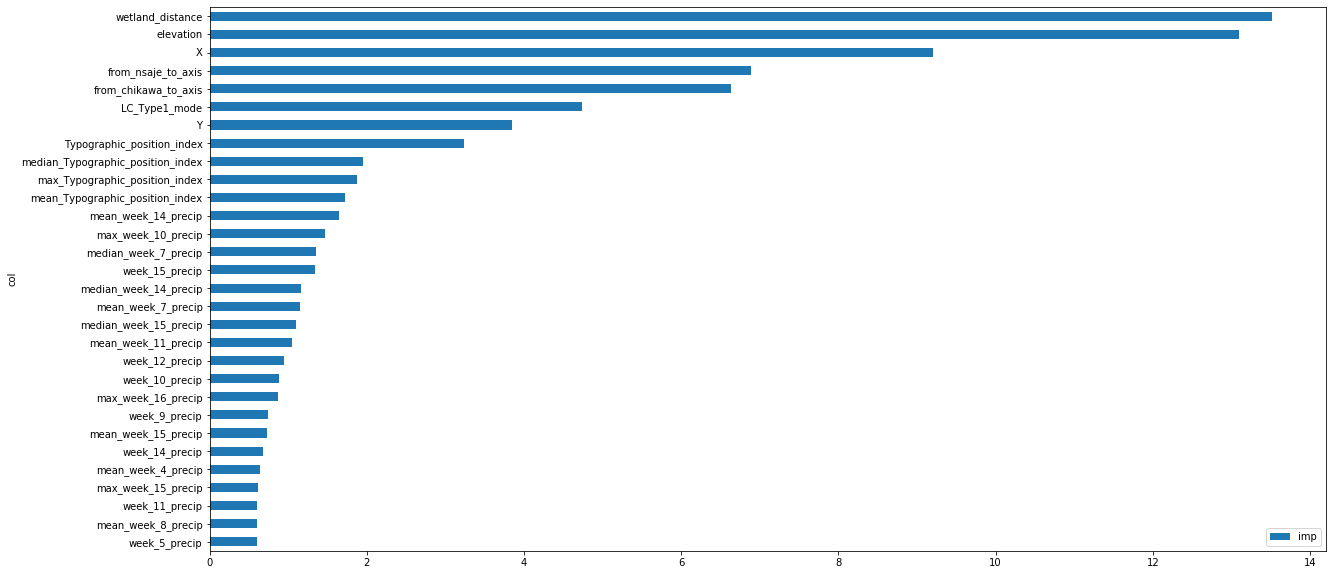

In [46]:
fea_imp = pd.DataFrame({'imp':m.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png')    

In [47]:
d = {"Square_ID": samp['Square_ID'], 'target_2015':np.mean(y_pred_totcb,0)}
test_predictions = pd.DataFrame(data=d)
test_predictions = test_predictions[["Square_ID", 'target_2015']]

In [48]:
test_predictions.head()

,Square_ID,target_2015
0,4e3c3896-14ce-11ea-bce5-f49634744a41,0.000658
1,4e3c3897-14ce-11ea-bce5-f49634744a41,0.000963
2,4e3c3898-14ce-11ea-bce5-f49634744a41,0.000390
3,4e3c3899-14ce-11ea-bce5-f49634744a41,0.000184
4,4e3c389a-14ce-11ea-bce5-f49634744a41,0.000514


In [49]:
test_predictions.to_csv('MODELH.csv', index=False)